In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gdown

In [ ]:
!gdown 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:04<00:00, 75.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 27.4MB/s]


In [ ]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [ ]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv("Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
reviews = reviews[['Text', 'Score']]
# Retain only Text and Score

In [ ]:
reviews.isnull().values.any()
# There's no null values

False

In [ ]:
reviews.loc[reviews['Score'] <=2, 'Score'] = 0
reviews.loc[reviews['Score'] > 3, 'Score'] = 1
reviews.drop(reviews[reviews['Score']==3].index,inplace=True)
# set score values and drop score withe the column value as 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<font size=4>Grader function 2 </font>

In [ ]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [ ]:
reviews['Text']=reviews['Text'].apply(lambda row : re.sub('<.*?>','',row))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews[['Text', 'len']], reviews.Score, test_size=0.2, stratify=reviews.Score)

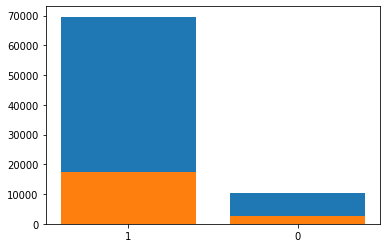

In [ ]:
ytrain = y_train.value_counts().to_dict()
plt.bar([str(x) for x in ytrain.keys()],list(ytrain.values()))
ytest = y_test.value_counts().to_dict()
plt.bar([str(x) for x in ytest.keys()],list(ytest.values()))
plt.show()

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
vocab_file

b'/tmp/tfhub_modules/03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/assets/vocab.txt'

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.2 MB/s 


In [ ]:
import tokenization 

In [ ]:
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
def bert_preprocess(sentences,tokenizer,max_seq_len=512):
  tokens=[]
  masks=[]
  segments=[]
  for sent in sentences:
    sent=tokenizer.tokenize(sent)
    sent=sent[:max_seq_len-2]
    seq=["[CLS]"] + sent + ["[SEP]"]
    token = tokenizer.convert_tokens_to_ids(seq)
    padding_tokens=token+[0]*(max_seq_len-len(token))
    mask=[1]*len(seq)
    masking=mask+[0]*(max_seq_len-len(token))
    segment=np.zeros(max_seq_length)
    
    tokens.append(padding_tokens)
    masks.append(masking)
    segments.append(segment)
  return np.array(tokens),np.array(masks),np.array(segments)

In [ ]:
data = pd.read_csv('/content/preprocessed.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['Text', 'len']], data.Score, test_size=0.2, stratify=data.Score)

In [ ]:
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.Text.values,tokenizer,55)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.Text.values,tokenizer,55)

In [ ]:
import pickle

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [ ]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
X_train_pooled_output_seq=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
# X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [ ]:
import datetime
from sklearn.metrics import roc_auc_score

In [ ]:
auc=[]
val_auc=[]
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.history={'val_accuracy': []}
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy', -1) != -1:
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
    auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
    auc_test=(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) )
    print('\n  train_auc : ',auc_tr)
    print('  val_auc : ',auc_test)
    auc.append(auc_tr)
    val_auc.append(auc_test)
    loss=logs.get('loss')

In [ ]:
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')
history_own = LossHistory()
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

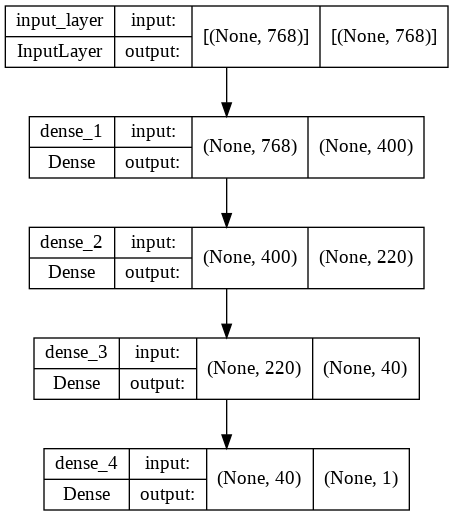

In [ ]:
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model1,"model_1.png",show_shapes=True)

In [ ]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,loss="binary_crossentropy", metrics='accuracy')

In [ ]:
model1.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=50,callbacks=[history_own])

Epoch 1/50
2498/2500 [============================>.] - ETA: 0s - loss: 0.2429 - accuracy: 0.9004
  train_auc :  0.9456140625940032
  val_auc :  0.9455435232026287
2500/2500 [==============================] - 17s 6ms/step - loss: 0.2429 - accuracy: 0.9004 - val_loss: 0.1944 - val_accuracy: 0.9255
Epoch 2/50
2496/2500 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9155
  train_auc :  0.9496298917100972
  val_auc :  0.949749065780783
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2044 - accuracy: 0.9156 - val_loss: 0.1805 - val_accuracy: 0.9273
Epoch 3/50
2497/2500 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9190
  train_auc :  0.9518358644397206
  val_auc :  0.9513460736789682
2500/2500 [==============================] - 18s 7ms/step - loss: 0.1981 - accuracy: 0.9190 - val_loss: 0.1762 - val_accuracy: 0.9279
Epoch 4/50
2487/2500 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9207
  train_a

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
!gdown 1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo

Downloading...
From: https://drive.google.com/uc?id=1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo
To: /content/test.csv
100% 62.1k/62.1k [00:00<00:00, 74.6MB/s]


In [ ]:
test_df= pd.read_csv('test.csv')

In [ ]:
def output_func(predictions):
  if predictions > 0.5:
    return 1
  else:
    return 0

In [ ]:
vfunc = np.vectorize(output_func)

In [ ]:
def data_pipeline(x_test,model1,bert_model):
  x_test['Text']=x_test['Text'].apply(lambda row : re.sub('<.*?>','',row))
  x_test_tokens, x_test_mask, x_test_segment=bert_preprocess(x_test.Text.values,tokenizer,55)
  x_test_pooled_output=bert_model.predict([x_test_tokens,x_test_mask,x_test_segment])
  predictions = model1.predict(x_test_pooled_output)
  final_output = vfunc(predictions)
  print(x_test_pooled_output.shape)
  return final_output

In [ ]:
final_output = data_pipeline(test_df,model1,bert_model)

(352, 768)


In [ ]:
print(test_df.shape)
print(final_output.shape)

(352, 1)
(352, 1)


Observation

I read through Jay Alammar's blog, I tried to implement sequence output [:,0,:] where I can get only CLS from the sequence output as one of the kaggle comment said it gave better result. But I had memory exceeding issues. 

I then used the output from BERT as input to my NN model.

For creating the data pipeling I wrote a simple function and used a bert preprocess function and another vectorize function inside my data pipeline function.

The 2 important take aways for me where that, I learned about [CLS] token in detail. And also the input structure of BERT.

I also came across a kaggle discussion where they said, glove gave better results for sentence for text similarity because of which they created SBERT.